# **고객기반 군집화**

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 12 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Scaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# Models
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as GMM
from sklearn.cluster import Birch

import datetime as dt
import time as tm
sns.set(font="NanumBarunGothic", 
rc={"axes.unicode_minus":False}, style='white')
plt.rc('font', family='NanumBarunGothic') 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. user 기반 데이터 생성

In [ ]:
loan_user_join=pd.read_csv("join_done (1)_productscore업데이트전.csv")

In [ ]:
# gender, age_group, purpose
basic_spec=pd.read_csv("basic_spec.csv")
basic_spec=basic_spec.rename({'0_x':'gender','0_y':'age_group','0':'purpose'},axis=1)

In [ ]:
# existing_loan_cnt
clustfea_1=pd.DataFrame(loan_user_join.groupby(['user_id']).apply(lambda x: x['existing_loan_cnt'].value_counts().index[0]))
clustfea_1=clustfea_1.rename(columns={0:'existing_loan_cnt'})
clustfea_1.to_csv("clustfea_1.csv")

In [ ]:
# credit_score
clustfea_2=pd.DataFrame(loan_user_join.groupby(['user_id'])['credit_score'].mean())

In [ ]:
# yearly_income
clustfea_2['yearly_income']=loan_user_join.groupby(['user_id'])['yearly_income'].mean()
clustfea_2.drop(['yearly_income_1'],axis=1,inplace=True)
clustfea_2.to_csv("clustfea_2.csv")

In [ ]:
# personal_rehabilitation
loan_user_join['loanapply_insert_time'] = pd.to_datetime(loan_user_join['loanapply_insert_time'])
loan_user_join=loan_user_join.sort_values(by=['loanapply_insert_time'])

In [ ]:
loan_user_join.groupby(['user_id','loanapply_insert_time'])['personal_rehabilitation'].value_counts().head(30)

user_id  loanapply_insert_time  personal_rehabilitation
9.0      2022-05-21 23:41:09    3.0                         4
         2022-05-21 23:41:10    3.0                        12
         2022-05-21 23:41:11    3.0                         4
         2022-05-21 23:41:14    3.0                         1
         2022-05-21 23:41:15    3.0                         1
         2022-05-21 23:41:16    3.0                         1
         2022-05-21 23:41:20    3.0                         1
         2022-05-21 23:41:22    3.0                         1
         2022-05-21 23:41:30    3.0                         1
11.0     2022-03-24 10:58:22    3.0                         1
         2022-03-24 10:58:23    3.0                         5
         2022-03-24 10:58:24    3.0                        15
         2022-03-24 10:58:31    3.0                         1
         2022-03-24 10:58:34    3.0                         1
         2022-03-24 10:58:35    3.0                         1
         2022-

In [ ]:
loan_user_join.groupby('user_id')['personal_rehabilitation'].unique()[loan_user_join.groupby('user_id')['personal_rehabilitation'].nunique()>1]

user_id
24.0        [3.0, 1.0]
1790.0      [3.0, 1.0]
1925.0      [2.0, 3.0]
2180.0      [3.0, 1.0]
2195.0      [3.0, 1.0]
               ...    
877074.0    [3.0, 1.0]
877445.0    [3.0, 1.0]
877915.0    [3.0, 1.0]
878285.0    [3.0, 1.0]
878308.0    [3.0, 1.0]
Name: personal_rehabilitation, Length: 1351, dtype: object

In [ ]:
loan_user_join[loan_user_join['user_id']==1790][['loanapply_insert_time','personal_rehabilitation']]

,loanapply_insert_time,personal_rehabilitation
526833,2022-04-22 21:07:25,3.0
526834,2022-04-22 21:07:26,3.0
526835,2022-04-22 21:07:32,3.0
10765061,2022-04-28 15:21:01,3.0
10765062,2022-04-28 15:21:01,3.0
...,...,...
1777330,2022-05-30 11:07:47,3.0
1777331,2022-05-30 11:07:48,3.0
1777332,2022-05-30 11:07:49,3.0
1777333,2022-05-30 11:07:55,3.0


In [ ]:
test=loan_user_join[['user_id','loanapply_insert_time','personal_rehabilitation']]
idx=test.groupby(['user_id'], as_index=False)['loanapply_insert_time'].max()
result=test.merge(idx,on=['user_id','loanapply_insert_time'],how='inner')
result[result['user_id']==24]

,user_id,loanapply_insert_time,personal_rehabilitation
205547,24.0,2022-05-16 09:28:50,1.0
205548,24.0,2022-05-16 09:28:50,1.0


In [ ]:
clustfea_6=result.drop(['loanapply_insert_time'],axis=1)
clustfea_6=clustfea_6.drop_duplicates()
clustfea_6=clustfea_6.set_index('user_id')
clustfea_6.to_csv("clustfea_6.csv")

In [ ]:
# avg_loan_limit
clustfea_8=pd.DataFrame(loan_user_join.groupby(['user_id'])['avg_loan_limit'].mean())
clustfea_8.to_csv("clustfea_8.csv")

# avg_loan_rate
clustfea_9=pd.DataFrame(loan_user_join.groupby(['user_id'])['avg_loan_rate'].mean())
clustfea_9.to_csv("clustfea_9.csv")

In [ ]:
# desired_amount
loan_user_join.groupby('user_id')['desired_amount'].nunique().describe()

count    317328.000000
mean          1.729403
std           1.207617
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          21.000000
Name: desired_amount, dtype: float64

In [ ]:
clustfea_4=pd.DataFrame(loan_user_join.groupby(['user_id'])['desired_amount'].mean())
clustfea_4.to_csv("clustfea_4.csv")

In [ ]:
# count of is_applied
loan_cnt = pd.DataFrame(loan_user_join[['user_id', 'is_applied']].groupby('user_id')['is_applied'].sum())
loan_cnt.columns=['loan_cnt']
loan_cnt.to_csv('clustfea_5.csv')

In [ ]:
loan_cnt.shape

(317328, 1)

## 데이터 병합

In [ ]:
zero=pd.read_csv("basic_spec.csv")
one=pd.read_csv("clustfea_1.csv")
two=pd.read_csv("clustfea_2.csv")
four=pd.read_csv("clustfea_4.csv")
five=pd.read_csv("clustfea_5.csv")
six=pd.read_csv("clustfea_6.csv")
eight=pd.read_csv("clustfea_8.csv")
nine=pd.read_csv("clustfea_9.csv")

In [ ]:
print(zero.shape)
print(one.shape)
print(two.shape)
print(four.shape)
print(five.shape)
print(six.shape)
print(eight.shape)
print(nine.shape)

(317328, 4)
(317328, 2)
(317328, 3)
(317328, 2)
(317328, 2)
(317328, 2)
(317328, 2)
(317328, 2)


In [ ]:
zero=zero.rename({'0_x':'gender','0_y':'age_group','0':'purpose'},axis=1)
one=one.rename({'0':'existing_loan_cnt'},axis=1)
total=zero.merge(one,on='user_id',how='inner')
total=total.merge(two,on='user_id',how='inner')
total=total.merge(four,on='user_id',how='inner')
total=total.merge(five,on='user_id',how='inner')
total=total.merge(six,on='user_id',how='inner')
total=total.merge(eight,on='user_id',how='inner')
total=total.merge(nine,on='user_id',how='inner')

In [ ]:
total.to_csv("clustfea_1.csv")

# 2. 상관성 확인

In [ ]:
corr=total.corr()
corr

,user_id,gender,age_group,existing_loan_cnt,credit_score,yearly_income,desired_amount,loan_cnt,personal_rehabilitation,avg_loan_limit,avg_loan_rate
user_id,1.000000,0.002867,-0.002345,-0.000805,0.002370,0.001496,0.000391,0.001792,-0.003317,0.004635,-0.002984
gender,0.002867,1.000000,-0.049429,0.009442,0.058064,0.035995,0.020616,0.006791,0.005375,0.117126,-0.023232
age_group,-0.002345,-0.049429,1.000000,0.098628,0.011754,0.067964,0.020991,-0.045383,-0.018977,0.053114,0.031973
existing_loan_cnt,-0.000805,0.009442,0.098628,1.000000,-0.239961,0.006174,-0.037428,0.130993,0.022567,-0.184695,0.169260
credit_score,0.002370,0.058064,0.011754,-0.239961,1.000000,0.053344,0.131981,-0.169954,0.067385,0.465843,-0.356504
yearly_income,0.001496,0.035995,0.067964,0.006174,0.053344,1.000000,0.149390,-0.008182,0.005953,0.147356,-0.008858
desired_amount,0.000391,0.020616,0.020991,-0.037428,0.131981,0.149390,1.000000,-0.049969,0.003945,0.109178,-0.061362
loan_cnt,0.001792,0.006791,-0.045383,0.130993,-0.169954,-0.008182,-0.049969,1.000000,0.008063,-0.087191,-0.015001
personal_rehabilitation,-0.003317,0.005375,-0.018977,0.022567,0.067385,0.005953,0.003945,0.008063,1.000000,0.006824,0.008630
avg_loan_limit,0.004635,0.117126,0.053114,-0.184695,0.465843,0.147356,0.109178,-0.087191,0.006824,1.000000,-0.276056


# 3. 라벨 인코딩

In [ ]:
total=total.drop(['user_id'],axis=1)

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le_result = total[['age_group','purpose']].apply(le.fit_transform)
le_result

,age_group,purpose
0,0,2
1,0,1
2,3,1
3,1,3
4,1,3
...,...,...
317323,1,3
317324,0,3
317325,0,1
317326,0,3


In [ ]:
le_result['age_group'].value_counts()

1    103510
2     95446
0     51595
3     49015
4     15095
5      2319
6       339
7         9
Name: age_group, dtype: int64

In [ ]:
total['age_group'].value_counts()

30.0    103510
40.0     95446
20.0     51595
50.0     49015
60.0     15095
70.0      2319
80.0       339
90.0         9
Name: age_group, dtype: int64

In [ ]:
le_result['purpose'].value_counts()

3    177647
1     85094
2     19836
5     11367
6      9677
0      8229
7      4299
4      1179
Name: purpose, dtype: int64

In [ ]:
total['purpose'].value_counts()

생활비       177647
대환대출       85094
사업자금       19836
전월세보증금     11367
주택구입        9677
기타          8229
투자          4299
자동차구입       1179
Name: purpose, dtype: int64

In [ ]:
total=total.drop(['age_group','purpose'],axis=1)
total2=pd.concat([total,le_result],axis=1)
total2

,gender,existing_loan_cnt,credit_score,yearly_income,desired_amount,loan_cnt,personal_rehabilitation,avg_loan_limit,avg_loan_rate,age_group,purpose
0,1.0,1.0,810.000000,2.900000e+07,1.500000e+07,0.0,3.0,2.073077e+07,11.976923,0,2
1,1.0,1.0,664.186047,2.683721e+07,2.176744e+07,3.0,3.0,1.720930e+07,13.685271,0,1
2,0.0,0.0,641.000000,2.700000e+07,3.000000e+07,0.0,3.0,1.750000e+07,16.800000,3,1
3,1.0,0.0,540.000000,5.000000e+07,7.200000e+06,2.0,3.0,2.660000e+07,18.300000,1,3
4,0.0,7.0,665.000000,0.000000e+00,2.000000e+07,0.0,3.0,5.000000e+06,13.800000,1,3
...,...,...,...,...,...,...,...,...,...,...,...
317323,1.0,3.0,790.000000,4.400000e+07,2.540000e+07,6.0,3.0,2.461667e+07,13.840000,1,3
317324,0.0,3.0,681.200000,2.400000e+07,3.240000e+06,2.0,3.0,1.448000e+07,17.916000,0,3
317325,1.0,0.0,643.000000,3.000000e+07,1.500000e+07,1.0,3.0,1.240000e+07,13.900000,0,1
317326,1.0,3.0,610.000000,3.700000e+07,1.000000e+07,3.0,3.0,1.168750e+07,11.562500,0,3


# 4. 변수 탐색

In [ ]:
total3=pd.read_csv("clustfea_labelencoding.csv")
total3=total3.drop(['Unnamed: 0'],axis=1)

In [ ]:
total3.shape

(317328, 14)

In [ ]:
total3.head()

,gender,existing_loan_cnt,credit_score,yearly_income,desired_amount,loan_cnt,personal_rehabilitation,avg_loan_limit,avg_loan_rate,age_group,purpose,income_type,employment_type,houseown_type
0,1.0,1.0,810.000000,2.900000e+07,1.500000e+07,0.0,3.0,2.073077e+07,11.976923,0,2.0,0.0,0.0,0.0
1,1.0,1.0,664.186047,2.683721e+07,2.176744e+07,3.0,3.0,1.720930e+07,13.685271,0,1.0,0.0,3.0,0.0
2,0.0,0.0,641.000000,2.700000e+07,3.000000e+07,0.0,3.0,1.750000e+07,16.800000,3,1.0,0.0,3.0,3.0
3,1.0,0.0,540.000000,5.000000e+07,7.200000e+06,2.0,3.0,2.660000e+07,18.300000,1,3.0,0.0,0.0,0.0
4,0.0,7.0,665.000000,0.000000e+00,2.000000e+07,0.0,3.0,5.000000e+06,13.800000,1,3.0,3.0,1.0,3.0


## 수치형

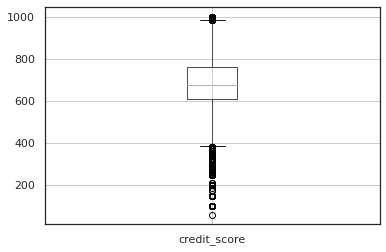

In [ ]:
columns=['credit_score','yearly_income','desired_amount','avg_loan_limit','avg_loan_rate']
total3.boxplot(column='credit_score')

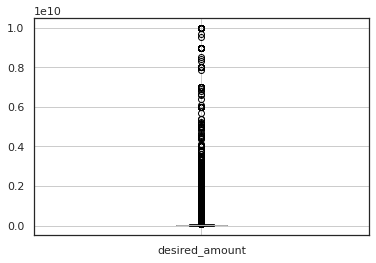

In [ ]:
columns=['credit_score','yearly_income','desired_amount','avg_loan_limit','avg_loan_rate']
total3.boxplot(column='desired_amount')

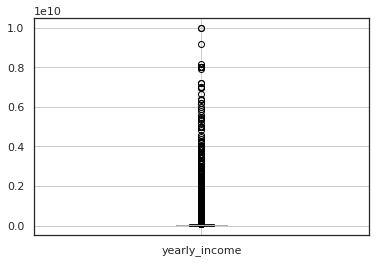

In [ ]:
total3.boxplot(column='yearly_income')

In [ ]:
total3['yearly_income'].describe()

count    3.173280e+05
mean     4.617834e+07
std      1.202281e+08
min      0.000000e+00
25%      2.527273e+07
50%      3.500000e+07
75%      5.000000e+07
max      1.000000e+10
Name: yearly_income, dtype: float64

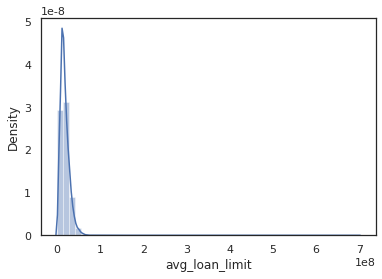

In [ ]:
sns.distplot(total3['avg_loan_limit'])

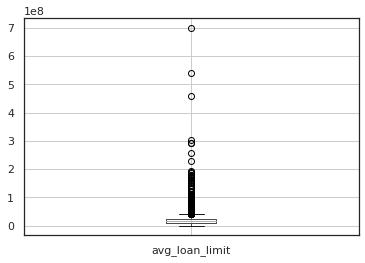

In [ ]:
total3.boxplot(column='avg_loan_limit')

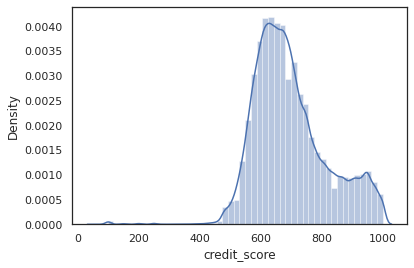

In [ ]:
sns.distplot(total3['credit_score'])

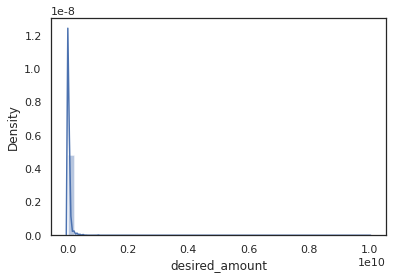

In [ ]:
sns.distplot(total3['desired_amount'])

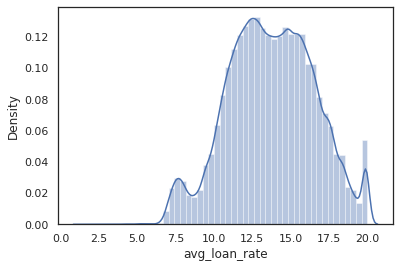

In [ ]:
sns.distplot(total3['avg_loan_rate'])

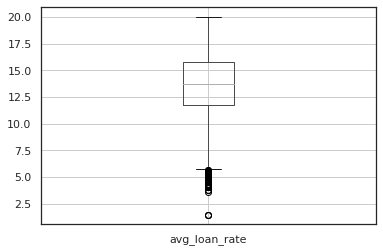

In [ ]:
total3.boxplot(column='avg_loan_rate')

In [ ]:
Q1 = total2['credit_score'].quantile(0.25)
Q3 = total2['credit_score'].quantile(0.75)
IQR = Q3 - Q1

In [ ]:
Q1 = total2.quantile(0.25)
Q3 = total2.quantile(0.75)
IQR = Q3 - Q1
((total2 < (Q1 - 1.5 * IQR)) | (total2 > (Q3 + 1.5 * IQR))).sum()

gender                         0
existing_loan_cnt           2070
credit_score                1662
yearly_income               7318
desired_amount             10385
loan_cnt                    8988
personal_rehabilitation      802
avg_loan_limit              3289
avg_loan_rate                 40
age_group                   6507
purpose                     1598
dtype: int64

In [ ]:
IQR

gender                     1.000000e+00
existing_loan_cnt          5.000000e+00
credit_score               1.500000e+02
yearly_income              2.495152e+07
desired_amount             3.031250e+07
loan_cnt                   2.000000e+00
personal_rehabilitation    0.000000e+00
avg_loan_limit             1.257647e+07
avg_loan_rate              4.017251e+00
age_group                  1.000000e+00
purpose                    2.000000e+00
dtype: float64

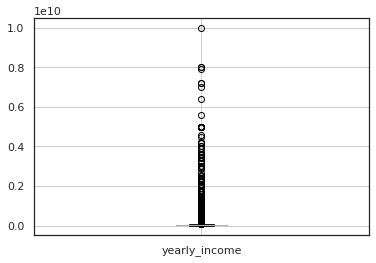

In [ ]:
total2.boxplot(column=['yearly_income'])

## 범주형

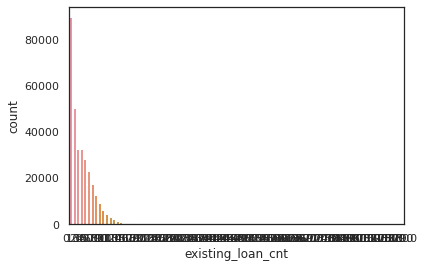

In [ ]:
sns.countplot(total3['existing_loan_cnt'])
#.set(title='user 1명이 갖고 있는 총 event 수의 분포')

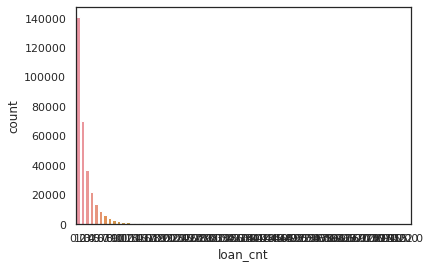

In [ ]:
sns.countplot(total3['loan_cnt'])

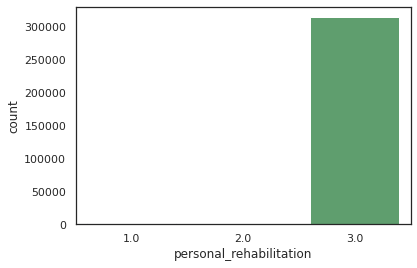

In [ ]:
sns.countplot(total3['personal_rehabilitation'])

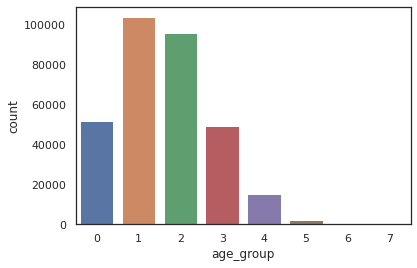

In [ ]:
sns.countplot(total3['age_group'])

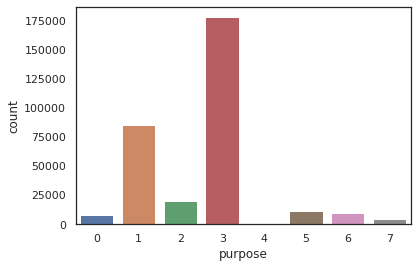

In [ ]:
sns.countplot(total3['purpose'])

# 5. 데이터 전처리

#### log-transformation

In [ ]:
total3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 317328 entries, 0 to 317327
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   gender                   317328 non-null  float64
 1   existing_loan_cnt        317328 non-null  float64
 2   credit_score             317328 non-null  float64
 3   yearly_income            317328 non-null  float64
 4   desired_amount           317328 non-null  float64
 5   loan_cnt                 317328 non-null  float64
 6   personal_rehabilitation  317328 non-null  float64
 7   avg_loan_limit           317328 non-null  float64
 8   avg_loan_rate            317328 non-null  float64
 9   age_group                317328 non-null  int64  
 10  purpose                  317328 non-null  int64  
 11  income_type              317328 non-null  int64  
 12  employment_type          317328 non-null  int64  
 13  houseown_type            317328 non-null  int64  
dtypes: f

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcfd2e4fe10>,
      dtype=object)

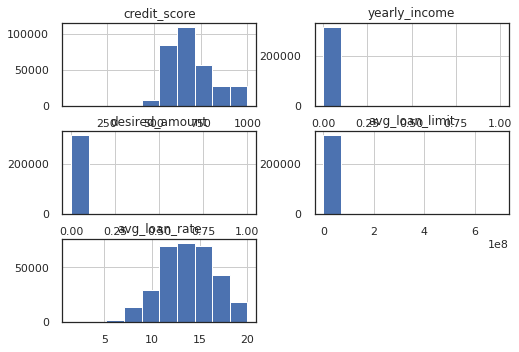

In [ ]:
total6=total3.copy()
columns=['credit_score','yearly_income','desired_amount','avg_loan_limit','avg_loan_rate']
total6[columns].hist()

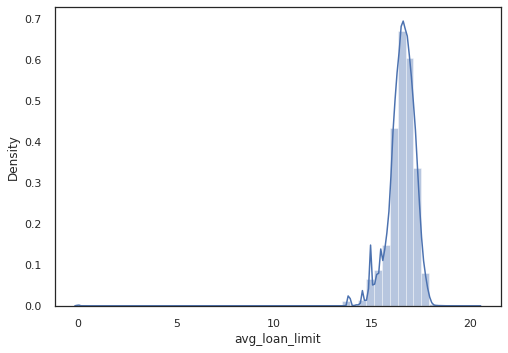

In [ ]:
columns=['credit_score','yearly_income','desired_amount','avg_loan_limit','avg_loan_rate']
sns.distplot(total6["avg_loan_limit"])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcfd233df10>,
      dtype=object)

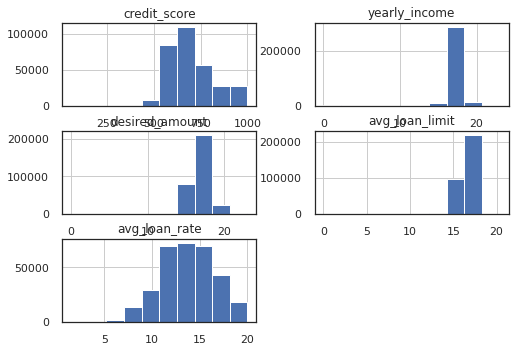

In [ ]:
total6['yearly_income'] = np.log1p(total6['yearly_income'])
total6['desired_amount'] = np.log1p(total6['desired_amount'])
total6['avg_loan_limit'] = np.log1p(total6['avg_loan_limit'])
total6[columns].hist()

## StandardScaler

In [ ]:
total3.dropna(inplace=True)
total3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 317328 entries, 0 to 317327
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   gender                   317328 non-null  float64
 1   existing_loan_cnt        317328 non-null  float64
 2   credit_score             317328 non-null  float64
 3   yearly_income            317328 non-null  float64
 4   desired_amount           317328 non-null  float64
 5   loan_cnt                 317328 non-null  float64
 6   personal_rehabilitation  317328 non-null  float64
 7   avg_loan_limit           317328 non-null  float64
 8   avg_loan_rate            317328 non-null  float64
 9   age_group                317328 non-null  int64  
 10  purpose                  317328 non-null  int64  
 11  income_type              317328 non-null  int64  
 12  employment_type          317328 non-null  int64  
 13  houseown_type            317328 non-null  int64  
dtypes: f

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
total6_s = scaler.fit_transform(total6)

total6_s = pd.DataFrame(data=total6_s, columns=total6.columns)
total6_s

,gender,existing_loan_cnt,credit_score,yearly_income,desired_amount,loan_cnt,personal_rehabilitation,avg_loan_limit,avg_loan_rate,age_group,purpose,income_type,employment_type,houseown_type
0,0.70624,-0.559342,0.934614,0.019979,-0.118957,-0.559955,0.084386,0.469467,-0.626008,-1.445030,-0.405872,-0.653135,-2.098107,-1.486702
1,0.70624,-0.559342,-0.277763,-0.017125,0.143043,0.401311,0.084386,0.207574,-0.017196,-1.445030,-1.151397,-0.653135,0.685055,-1.486702
2,-1.41595,-0.830986,-0.470545,-0.014230,0.368748,-0.559955,0.084386,0.231138,1.092815,1.223437,-1.151397,-0.653135,0.685055,0.883036
3,0.70624,-0.830986,-1.310314,0.280747,-0.635384,0.080889,0.084386,0.820160,1.627376,-0.555541,0.339652,-0.653135,-2.098107,-1.486702
4,-1.41595,1.070520,-0.270996,-8.205678,0.083459,-0.559955,0.084386,-1.531190,0.023691,-0.555541,0.339652,1.098543,-1.170386,0.883036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317323,0.70624,-0.016055,0.768323,0.219552,0.251633,1.362577,0.084386,0.711154,0.037946,-0.555541,0.339652,0.514650,-1.170386,-1.486702
317324,-1.41595,-0.016055,-0.136300,-0.070614,-1.197220,0.080889,0.084386,-0.035347,1.490529,-1.445030,0.339652,-0.653135,0.685055,0.883036
317325,0.70624,-0.830986,-0.453916,0.036208,-0.118957,-0.239533,0.084386,-0.253495,0.059328,-1.445030,-1.151397,-0.069242,0.685055,0.883036
317326,0.70624,-0.016055,-0.728296,0.136604,-0.404245,0.401311,0.084386,-0.336741,-0.773697,-1.445030,0.339652,-0.653135,0.685055,0.883036


# 6. GMM

In [ ]:
gmmdata=total6_s[['credit_score','yearly_income','desired_amount','existing_loan_cnt','income_type','purpose']]
gmmdata.shape

(317328, 6)

In [ ]:
def SelBest(arr:list, X:int)->list:
    dx=np.argsort(arr)[:X]
    return arr[dx]

In [ ]:
from sklearn.mixture import GaussianMixture as GMM

n_clusters=np.arange(3, 10)
bics=[]
bics_err=[]
iterations=6
for n in n_clusters:
    tmp_bic=[]
    for _ in range(iterations):
      gmm=GMM(n, n_init=2).fit(gmmdata) 
      tmp_bic.append(gmm.bic(gmmdata))

    val=np.mean(SelBest(np.array(tmp_bic), int(iterations/5)))
    err=np.std(tmp_bic)
    bics.append(val)
    bics_err.append(err)

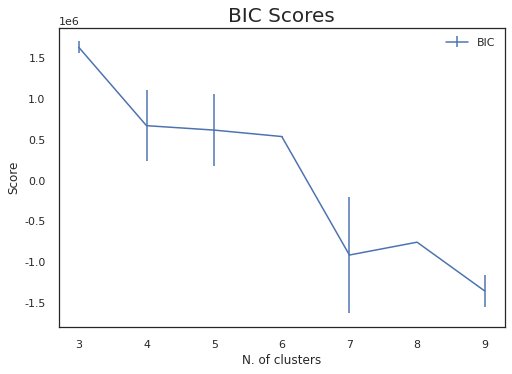

In [ ]:
plt.errorbar(n_clusters,bics, yerr=bics_err, label='BIC')
plt.title("BIC Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")
plt.legend()

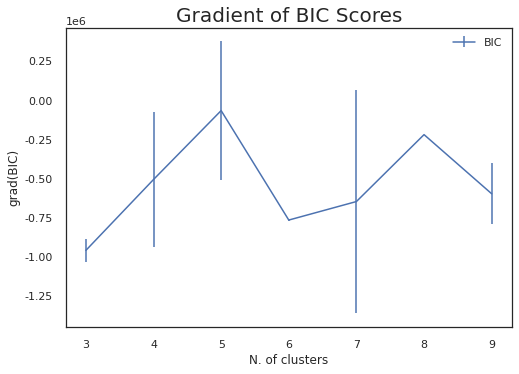

In [ ]:
plt.errorbar(n_clusters, np.gradient(bics), yerr=bics_err, label='BIC')
plt.title("Gradient of BIC Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("grad(BIC)")
plt.legend()

=> cluster 5

In [ ]:
gmm = GMM(n_components=5, random_state=42)
gmm_labels = gmm.fit_predict(gmmdata)

total6['gmm5_labels'] = gmm_labels
total6

,gender,existing_loan_cnt,credit_score,yearly_income,desired_amount,loan_cnt,personal_rehabilitation,avg_loan_limit,avg_loan_rate,age_group,purpose,income_type,employment_type,houseown_type,gmm5_labels
0,1.0,1.0,810.000000,17.182806,16.523561,0.0,3.0,16.847130,11.976923,0,2,0,0,0,4
1,1.0,1.0,664.186047,17.105300,16.895926,3.0,3.0,16.660961,13.685271,0,1,0,3,0,1
2,0.0,0.0,641.000000,17.111347,17.216708,0.0,3.0,16.677711,16.800000,3,1,0,3,3,1
3,1.0,0.0,540.000000,17.727534,15.789592,2.0,3.0,17.096422,18.300000,1,3,0,0,0,0
4,0.0,7.0,665.000000,0.000000,16.811243,0.0,3.0,15.424949,13.800000,1,3,3,1,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317323,1.0,3.0,790.000000,17.599700,17.050260,6.0,3.0,17.018934,13.840000,1,3,2,1,0,0
317324,0.0,3.0,681.200000,16.993564,14.991084,2.0,3.0,16.488279,17.916000,0,3,0,3,3,0
317325,1.0,0.0,643.000000,17.216708,16.523561,1.0,3.0,16.333207,13.900000,0,1,1,3,3,2
317326,1.0,3.0,610.000000,17.426428,16.118096,3.0,3.0,16.274031,11.562500,0,3,0,3,3,0


In [ ]:
total6.to_csv("userclustering_gmm.csv")

## 시각화

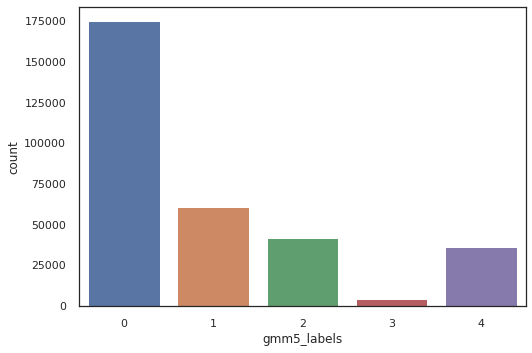

In [ ]:
sns.countplot(total6['gmm5_labels'])

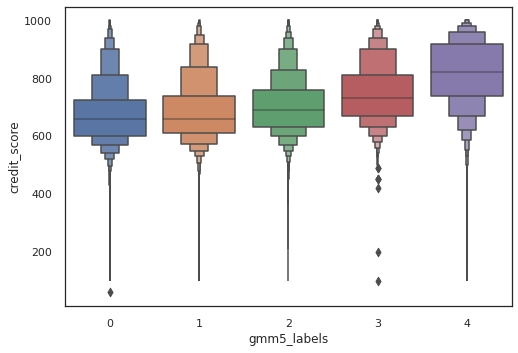

In [ ]:
sns.boxenplot(x=total6['gmm5_labels'], y=total6['credit_score'])

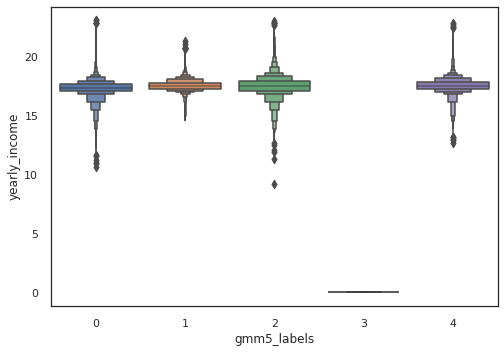

In [ ]:
sns.boxenplot(x=total6['gmm5_labels'], y=total6['yearly_income'])

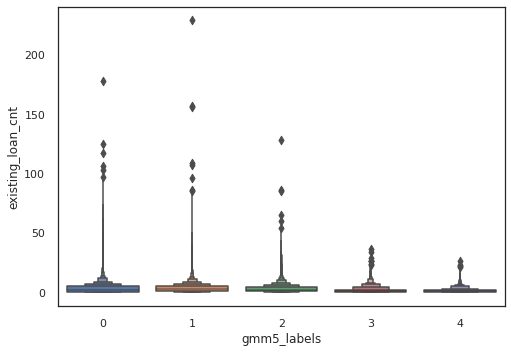

In [ ]:
sns.boxenplot(x=total6['gmm5_labels'], y=total6['existing_loan_cnt'])

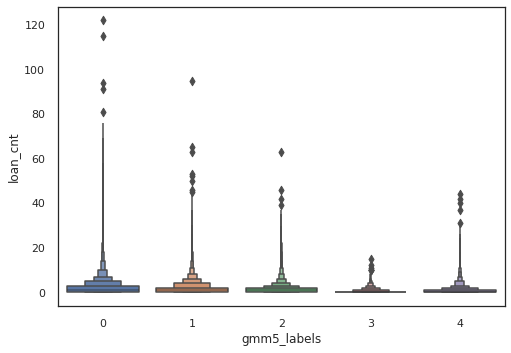

In [ ]:
sns.boxenplot(x=total6['gmm5_labels'], y=total6['loan_cnt'])

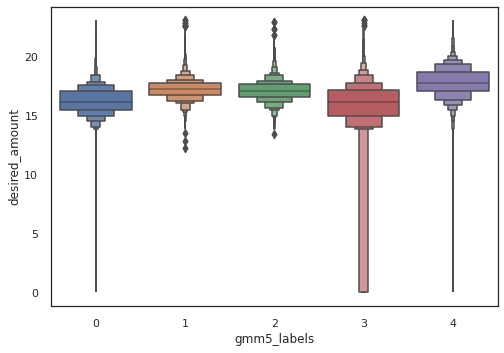

In [ ]:
sns.boxenplot(x=total6['gmm5_labels'], y=total6['desired_amount'])

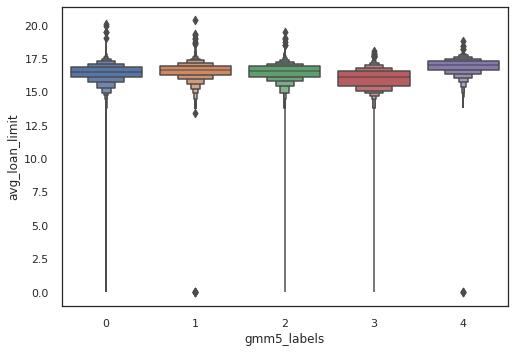

In [ ]:
sns.boxenplot(x=total6['gmm5_labels'], y=total6['avg_loan_limit'])

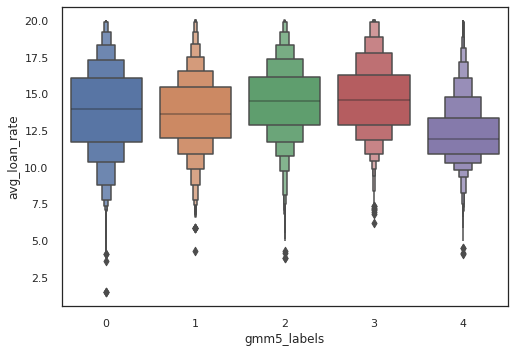

In [ ]:
sns.boxenplot(x=total6['gmm5_labels'], y=total6['avg_loan_rate'])

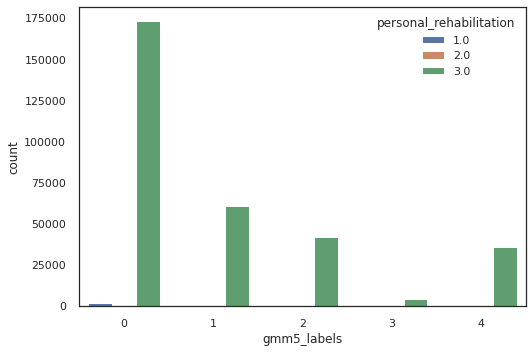

In [ ]:
sns.countplot(x=total6['gmm5_labels'],hue=total6['personal_rehabilitation'])

In [ ]:
total6.shape

(317328, 16)

In [ ]:
1-(177647+85094)/317328

0.17202074824786973

In [ ]:
total6.columns

Index(['gender', 'existing_loan_cnt', 'credit_score', 'yearly_income',
       'desired_amount', 'loan_cnt', 'personal_rehabilitation',
       'avg_loan_limit', 'avg_loan_rate', 'age_group', 'purpose',
       'income_type', 'employment_type', 'houseown_type', 'gmm5_labels',
       'birch3_labels'],
      dtype='object')

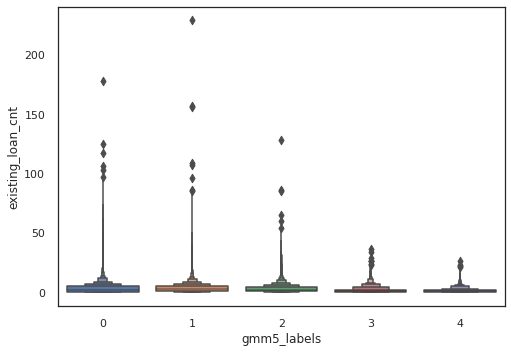

In [ ]:
sns.boxenplot(x=total6['gmm5_labels'], y=total6['existing_loan_cnt'])

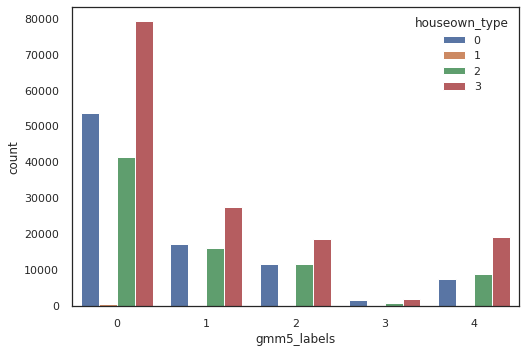

In [ ]:
sns.countplot(x=total6['gmm5_labels'],hue=total6['houseown_type'])

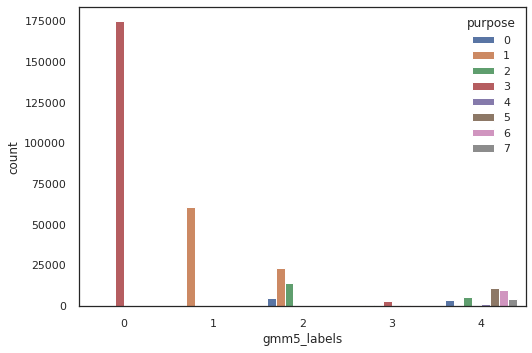

In [ ]:
sns.countplot(x=total6['gmm5_labels'],hue=total6['purpose'])

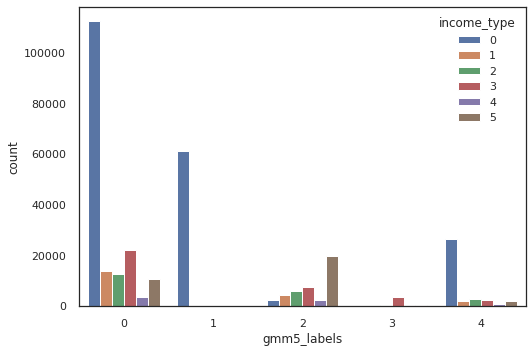

In [ ]:
sns.countplot(x=total6['gmm5_labels'],hue=total6['income_type'])

In [ ]:
def visualization_clustering(data):
  from sklearn.preprocessing import StandardScaler
  df = data.copy()
  labels = df['labels'].tolist()
  df.drop(['labels'], axis=1, inplace=True)
  cl = df.columns
  df = StandardScaler().fit_transform(df)
  df = pd.DataFrame(df, columns = cl)
  df['labels'] = labels
  t = pd.DataFrame(df.groupby('labels').mean().stack()).reset_index()


  sns.set_style('whitegrid')
  n = set(labels)
  fig, ax = plt.subplots(nrows=len(n),  figsize=(15, len(n)*3))
  for label in n:
    sns.barplot(x='level_1', y=0, data = t[t['labels']==label], ax=ax[label])
    plt.xticks(rotation=45)
    plt.subplots_adjust(hspace = 0.8)
    
    ax[label].axhline(color='red', linestyle='solid')
    ax[label].set(xlabel=None, ylabel=None)

In [ ]:
gmm5=total6.copy()
gmm5=gmm5.rename({'gmm5_labels':'labels'},axis=1)

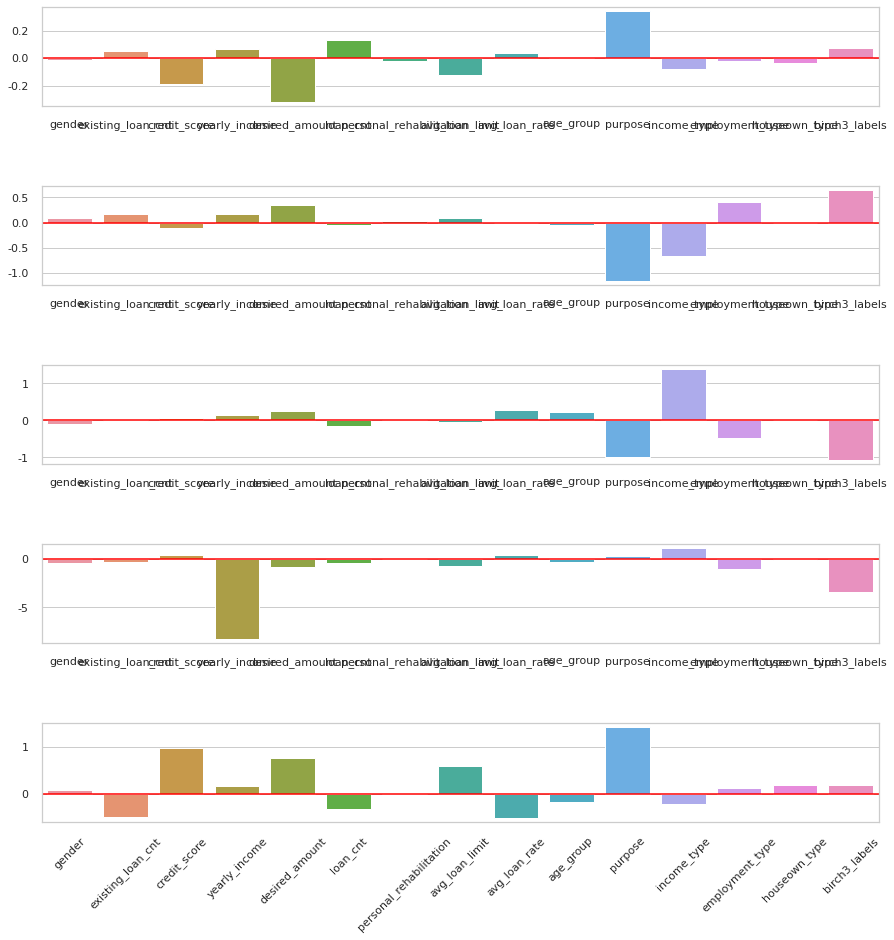

In [ ]:
visualization_clustering(gmm5)

# 7. BIRCH

In [ ]:
from sklearn.preprocessing import MinMaxScaler

col = total6.columns

scaler = MinMaxScaler()
total6_scaled = scaler.fit_transform(total6)
total6_scaled = pd.DataFrame(total6_scaled, columns=[col])
total6_scaled

,gender,existing_loan_cnt,credit_score,yearly_income,desired_amount,loan_cnt,personal_rehabilitation,avg_loan_limit,avg_loan_rate,age_group,purpose,income_type,employment_type,houseown_type,gmm5_labels
0,1.0,0.004367,0.797872,0.746240,0.717609,0.000000,1.0,0.827194,0.566320,0.000000,0.285714,0.0,0.000000,0.000000,1.00
1,1.0,0.004367,0.642751,0.742874,0.733781,0.024590,1.0,0.818053,0.658663,0.000000,0.142857,0.0,1.000000,0.000000,0.25
2,0.0,0.000000,0.618085,0.743136,0.747712,0.000000,1.0,0.818876,0.827027,0.428571,0.142857,0.0,1.000000,1.000000,0.25
3,1.0,0.000000,0.510638,0.769897,0.685733,0.016393,1.0,0.839435,0.908108,0.142857,0.428571,0.0,0.000000,0.000000,0.00
4,0.0,0.030568,0.643617,0.000000,0.730103,0.000000,1.0,0.757365,0.664865,0.142857,0.428571,0.6,0.333333,1.000000,0.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317323,1.0,0.013100,0.776596,0.764345,0.740483,0.049180,1.0,0.835630,0.667027,0.142857,0.428571,0.4,0.333333,0.000000,0.00
317324,0.0,0.013100,0.660851,0.738021,0.651055,0.016393,1.0,0.809575,0.887351,0.000000,0.428571,0.0,1.000000,1.000000,0.00
317325,1.0,0.000000,0.620213,0.747712,0.717609,0.008197,1.0,0.801961,0.670270,0.000000,0.142857,0.2,1.000000,1.000000,0.50
317326,1.0,0.013100,0.585106,0.756820,0.700000,0.024590,1.0,0.799055,0.543919,0.000000,0.428571,0.0,1.000000,1.000000,0.00


In [ ]:
birchdata=total6_scaled[['credit_score','yearly_income','desired_amount','existing_loan_cnt','income_type','purpose']]

Elbow Method to determine the number of clusters to be formed:


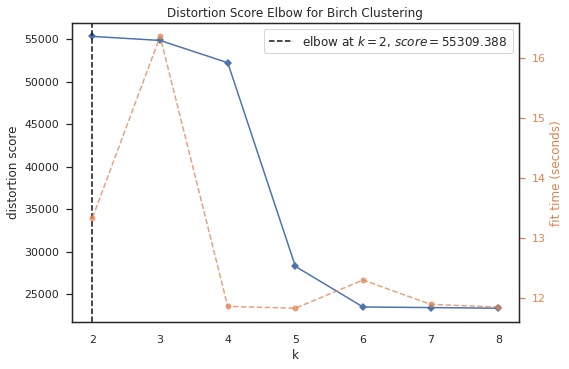

In [ ]:
BP = Birch(threshold=0.1)

print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(BP, k=(2, 9))
Elbow_M.fit(birchdata)
Elbow_M.show()

Elbow Method to determine the number of clusters to be formed:


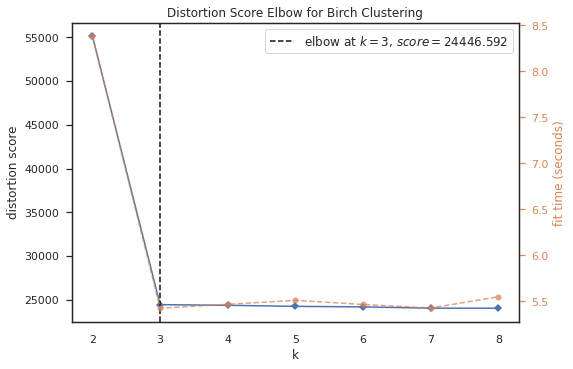

In [ ]:
BP = Birch(threshold=0.2)

print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(BP, k=(2, 9))
Elbow_M.fit(birchdata)
Elbow_M.show()

In [ ]:
model = Birch(threshold=0.2, n_clusters=3)
model.fit(birchdata)

pred = model.predict(birchdata)
total6['birch3_labels'] = pred

## 시각화

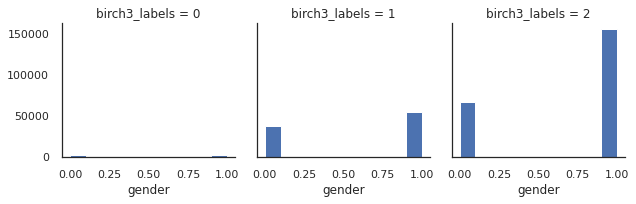

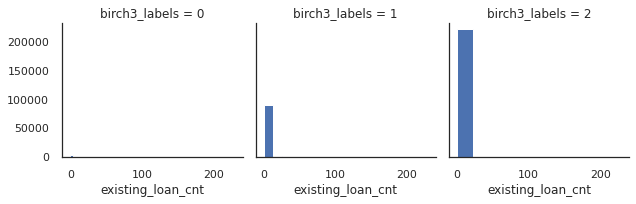

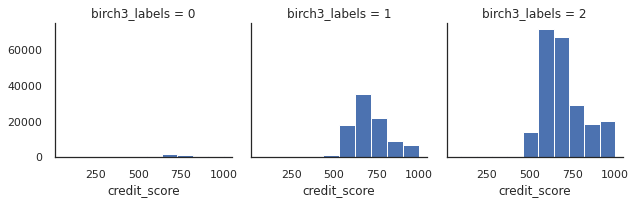

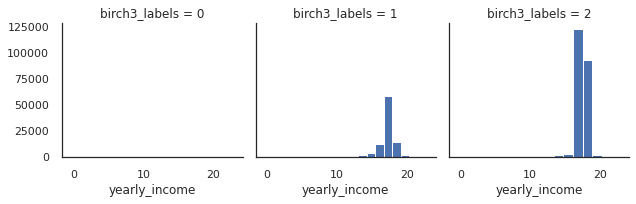

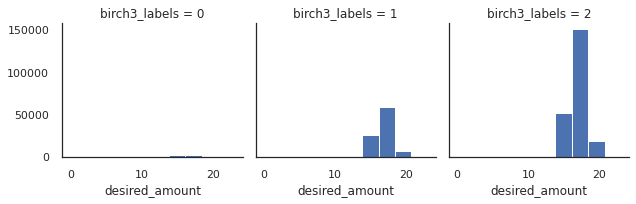

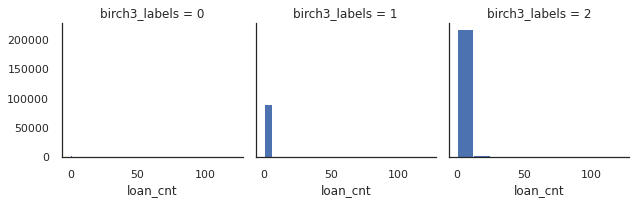

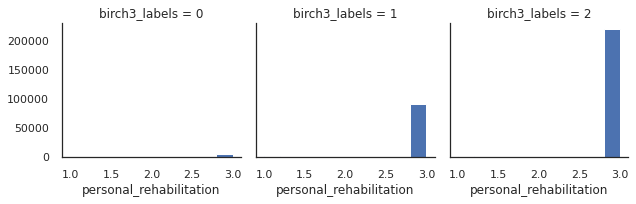

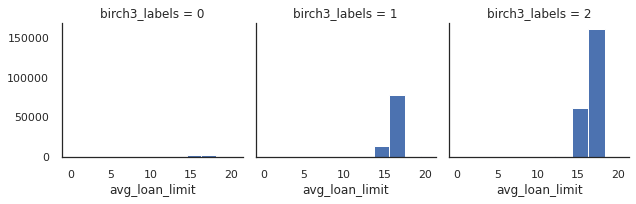

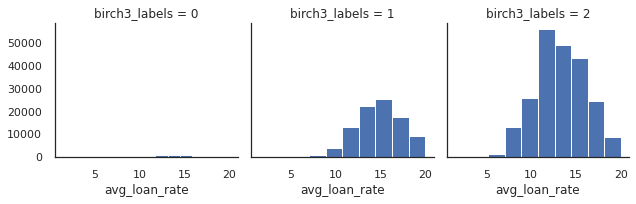

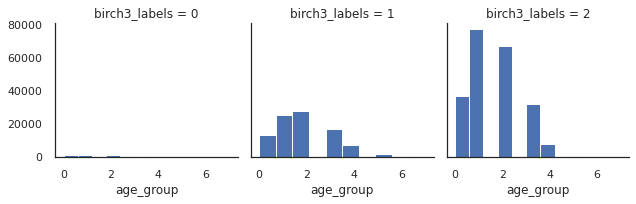

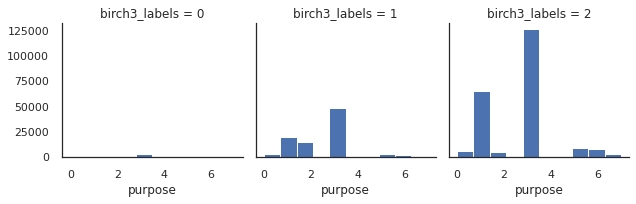

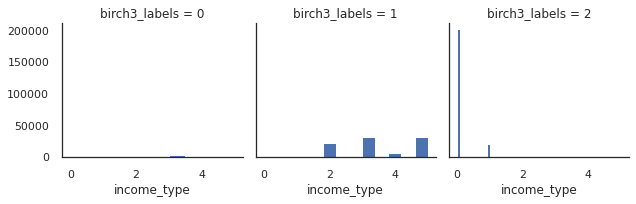

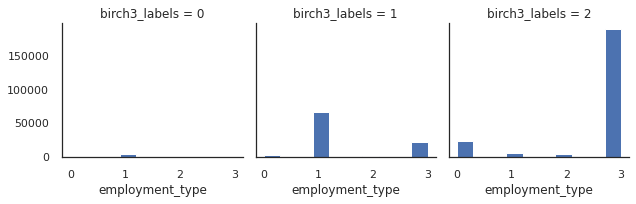

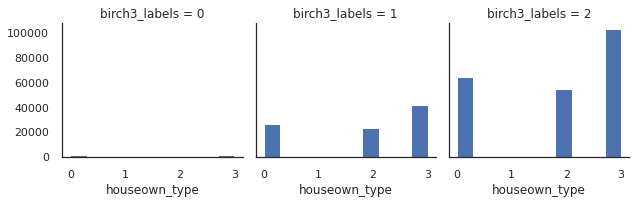

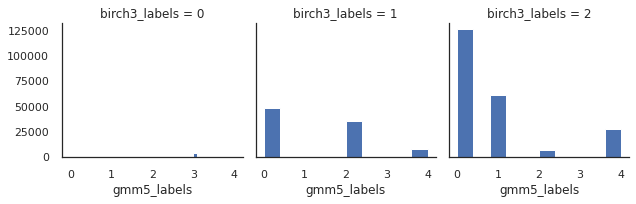

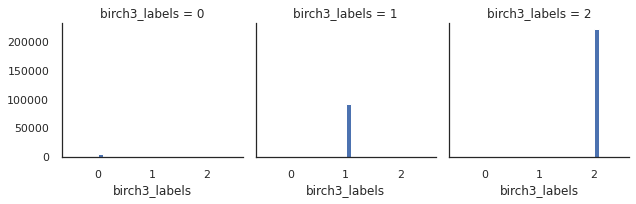

In [ ]:
for c in total6:
    grid= sns.FacetGrid(total6, col='birch3_labels')
    grid.map(plt.hist, c)

In [ ]:
total6.to_csv("total6_birch.csv")

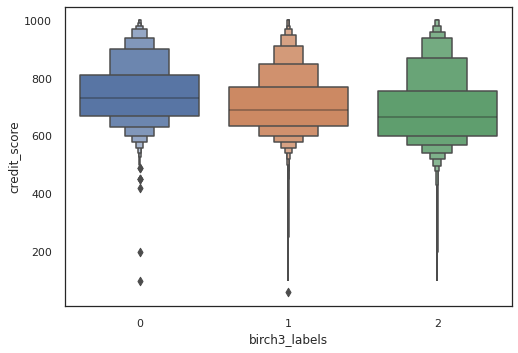

In [ ]:
sns.boxenplot(x=total6['birch3_labels'], y=total6['credit_score'])

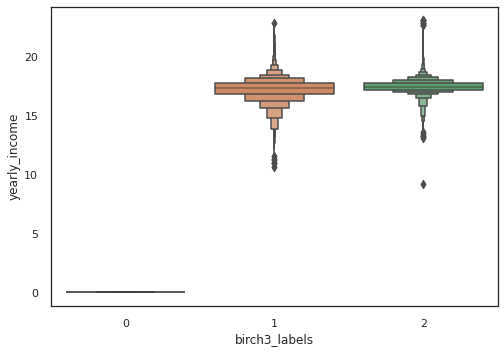

In [ ]:
sns.boxenplot(x=total6['birch3_labels'], y=total6['yearly_income'])

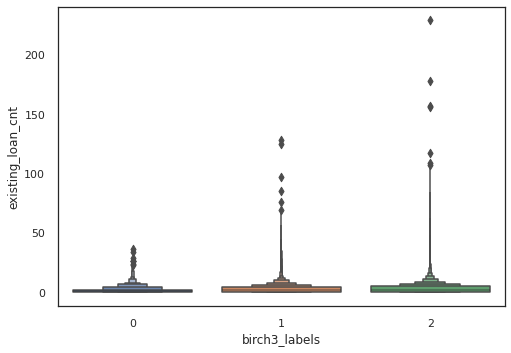

In [ ]:
sns.boxenplot(x=total6['birch3_labels'], y=total6['existing_loan_cnt'])

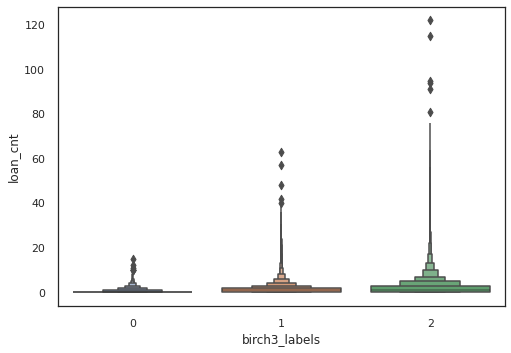

In [ ]:
sns.boxenplot(x=total6['birch3_labels'], y=total6['loan_cnt'])

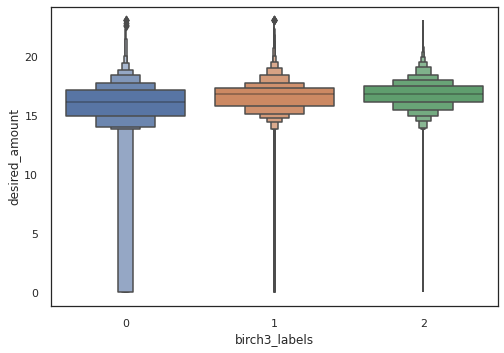

In [ ]:
sns.boxenplot(x=total6['birch3_labels'], y=total6['desired_amount'])

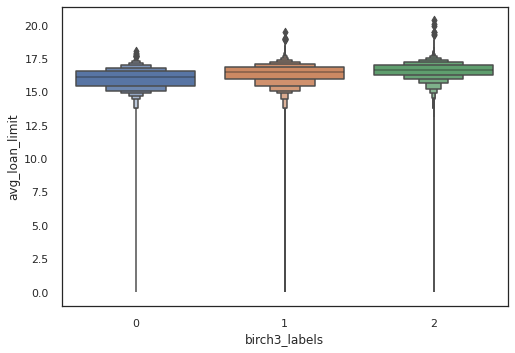

In [ ]:
sns.boxenplot(x=total6['birch3_labels'], y=total6['avg_loan_limit'])

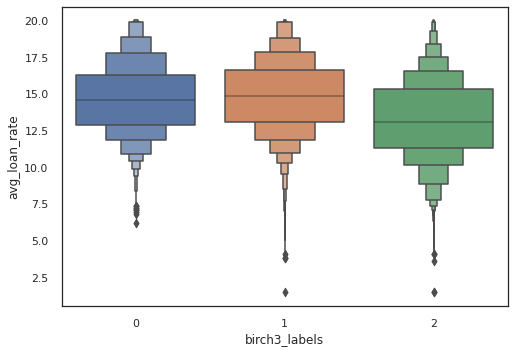

In [ ]:
sns.boxenplot(x=total6['birch3_labels'], y=total6['avg_loan_rate'])

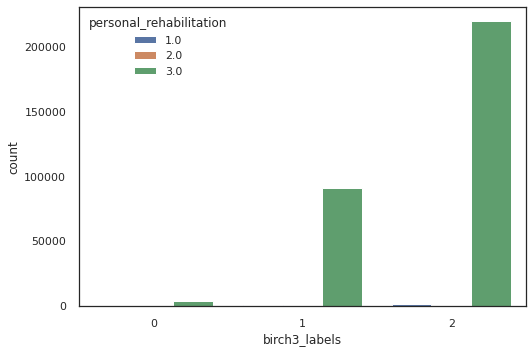

In [ ]:
sns.countplot(x=total6['birch3_labels'],hue=total6['personal_rehabilitation'])

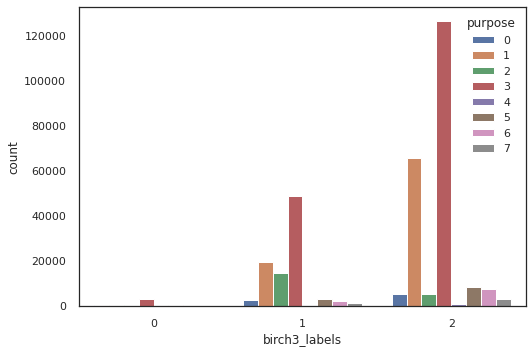

In [ ]:
sns.countplot(x=total6['birch3_labels'],hue=total6['purpose'])

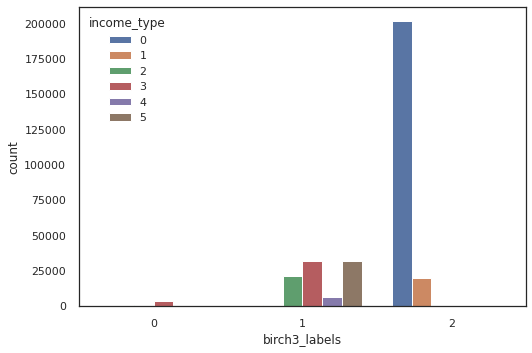

In [ ]:
sns.countplot(x=total6['birch3_labels'],hue=total6['income_type'])

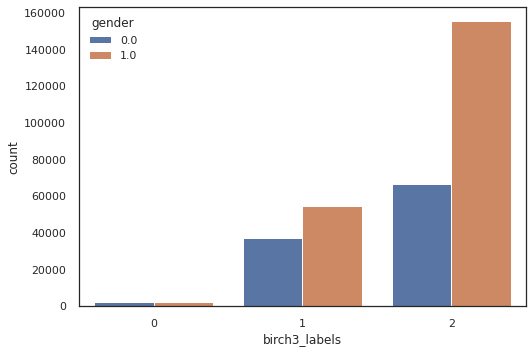

In [ ]:
sns.countplot(x=total6['birch3_labels'],hue=total6['gender'])

In [ ]:
gmm5=pd.read_csv("gmm5.csv")
index=pd.read_csv("basic_spec.csv")

In [ ]:
gmm5['user_id']=index['user_id']

In [ ]:
gmm5.columns

Index(['gender', 'existing_loan_cnt', 'credit_score', 'yearly_income',
       'desired_amount', 'loan_cnt', 'personal_rehabilitation',
       'avg_loan_limit', 'avg_loan_rate', 'age_group', 'purpose',
       'income_type', 'employment_type', 'houseown_type', 'gmm5_labels',
       'birch3_labels', 'user_id'],
      dtype='object')

In [ ]:
gmm5.to_csv("gmm5_userid.csv",index=False)